In [28]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [29]:
transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=128,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=128,
                                          shuffle=True)

In [30]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [31]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def add_noise(imgs, noise_factor=0.25):
    noisy = imgs + noise_factor * torch.randn_like(imgs)
    return torch.clamp(noisy, 0., 1.)


In [32]:
model = DenoisingAutoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=5e-3,
                             weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=3, verbose=True
)

In [33]:
losses=[]
outputs = []
num_epochs = 35
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        noisy_img = add_noise(img)
        recon = model(noisy_img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
    scheduler.step(loss.item())
    losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    outputs.append((epoch, noisy_img, recon))

Epoch 1, Loss: 0.0084
Epoch 2, Loss: 0.0069
Epoch 3, Loss: 0.0062
Epoch 4, Loss: 0.0060
Epoch 5, Loss: 0.0059
Epoch 6, Loss: 0.0061
Epoch 7, Loss: 0.0061
Epoch 8, Loss: 0.0062
Epoch 9, Loss: 0.0065
Epoch 10, Loss: 0.0058
Epoch 11, Loss: 0.0058
Epoch 12, Loss: 0.0060
Epoch 13, Loss: 0.0058
Epoch 14, Loss: 0.0056
Epoch 15, Loss: 0.0056
Epoch 16, Loss: 0.0055
Epoch 17, Loss: 0.0052
Epoch 18, Loss: 0.0055
Epoch 19, Loss: 0.0061
Epoch 20, Loss: 0.0050
Epoch 21, Loss: 0.0051
Epoch 22, Loss: 0.0056
Epoch 23, Loss: 0.0055
Epoch 24, Loss: 0.0055
Epoch 25, Loss: 0.0056
Epoch 26, Loss: 0.0054
Epoch 27, Loss: 0.0052
Epoch 28, Loss: 0.0055
Epoch 29, Loss: 0.0052
Epoch 30, Loss: 0.0053
Epoch 31, Loss: 0.0052
Epoch 32, Loss: 0.0052
Epoch 33, Loss: 0.0052
Epoch 34, Loss: 0.0049
Epoch 35, Loss: 0.0050


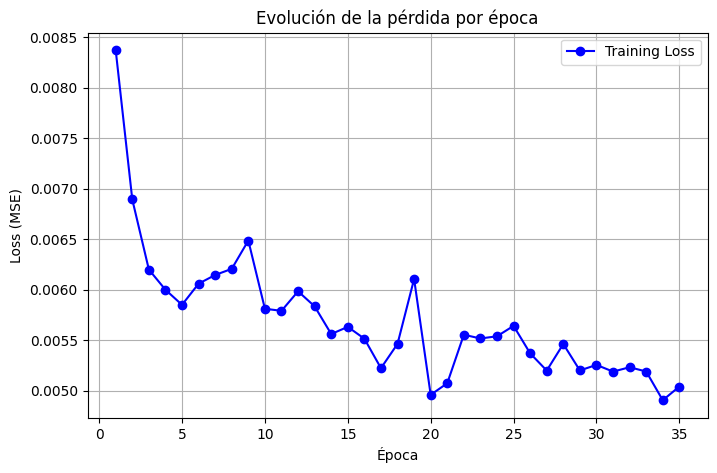

In [34]:
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), losses, marker='o', color='blue', label='Training Loss')
plt.title("Evolución de la pérdida por época")
plt.xlabel("Época")
plt.ylabel("Loss (MSE)")
plt.grid(True)
plt.legend()
plt.show()

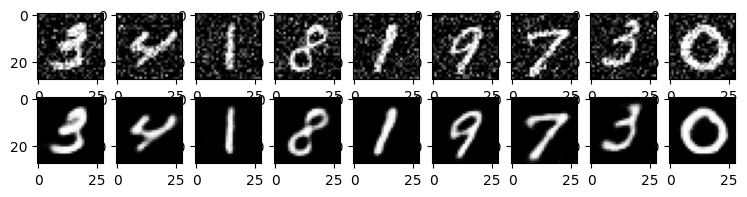

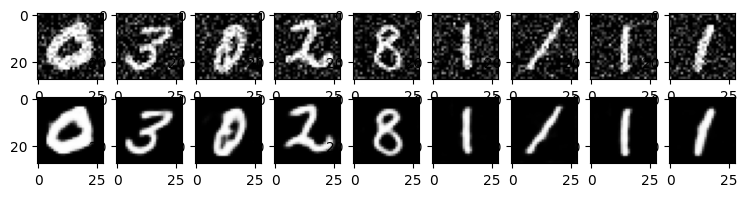

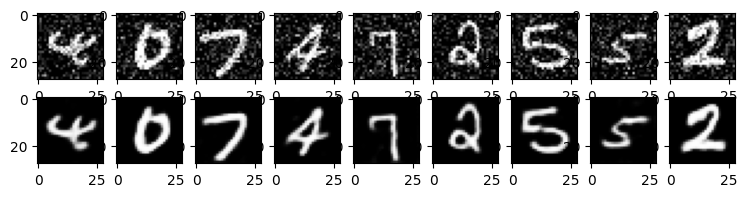

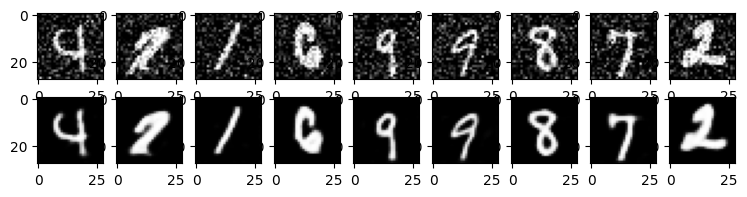

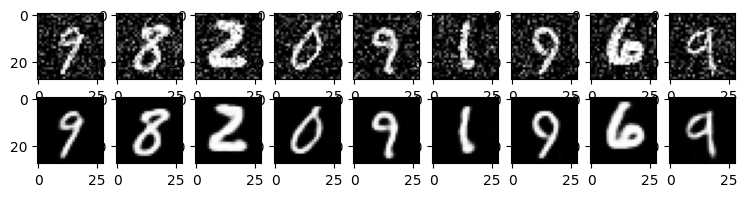

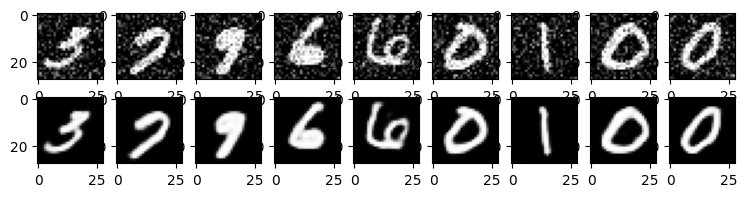

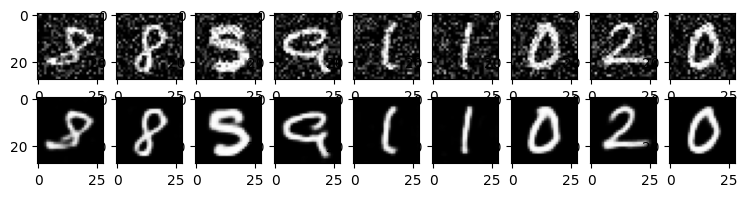

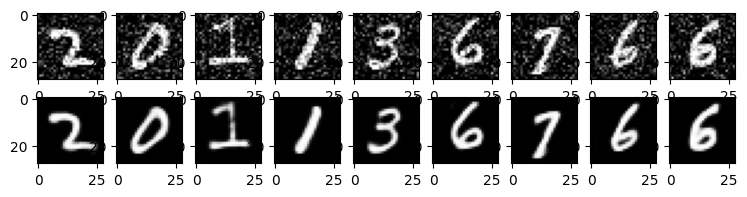

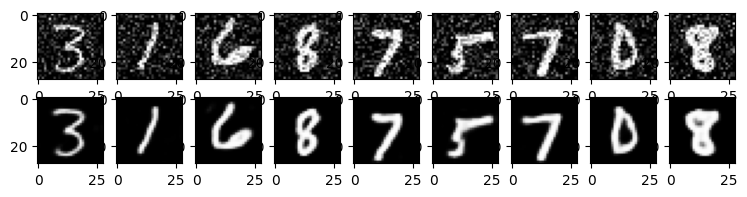

In [35]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0], cmap='gray')

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0], cmap='gray')

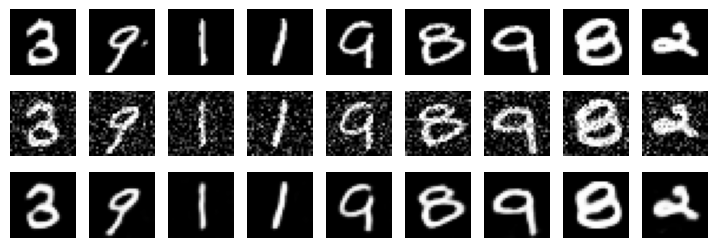

In [36]:
model.eval()
dataiter = iter(data_loader_valid)
images, _ = next(dataiter)
noisy_images = add_noise(images)

with torch.no_grad():
    outputs = model(noisy_images)

plt.figure(figsize=(9,3))
for i in range(9):
    # Original
    plt.subplot(3,9,i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.axis('off')
    # Noisy
    plt.subplot(3,9,9+i+1)
    plt.imshow(noisy_images[i][0], cmap='gray')
    plt.axis('off')
    # Reconstruido
    plt.subplot(3,9,18+i+1)
    plt.imshow(outputs[i][0], cmap='gray')
    plt.axis('off')
plt.show()
